# Computer Vision and Image Processing M
## Augmented reality project
### Cristian Davide Conte - 0001034932

***Goal:***
Students should develop a software system aimed at creating an Augmented Reality (AR) video.

***Characteristics of the video sequence:*** The original **video** sequence, i.e. Multiple View.avi, **depicts the well-known book “Multiple View
Geometry in Computer Vision”**, by Richard Hartley and Andrew Zissermann, as **seen by a moving
camera**. Initially, camera trajectory is a slow translation, followed then by rotations and slow as well
as rapid brightness changes. 

***Functional specifications:*** 
Given the input video, students should **superimpose an augmented reality layer onto the book cover**
as realistically as possible, so that, ideally, when watching the augmented video one would perceive
the overlaid graphics as real items present in the book cover. Purposely, the **colour artefacts**
appearing when superimposing the graphics layer **should be eliminated.**

***Input Data:***
The augmented reality system should process the following input data:
- Input video sequence to be augmented: Multiple View.avi
- Reference frame (first frame of the input sequence): ReferenceFrame.png
- Binary mask that identifies the pixels belonging to the book in the reference frame:
ObjectMask.png
- Image containing the augmented reality layer, made out of the CVLab logo and a different
list of authors (i.e. Richard Hartley and Andrew Zissermann and Pietro Azzari) together
with the associated binary mask: AugmentedLayer.png, AugmentedLayerMask.png

***Output Data:***
The developed software system should produce the following output data:
- A video sequence, referred to here as "Augmented Multiple View.avi", containing realistic
superimposition of the augmented reality layer onto the input video sequence. 

# 0 - Imports and utilities

Import the needed libraries and create some useful constants/functions

In [1]:
import os
import time
import cv2
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from IPython.display import clear_output

# Useful constants
MIN_MATCH_COUNT = 10
FLANN_INDEX_KDTREE = 1
TOT_FRAMES_NUM = 420
SIFT_FREQUENCY_2C = 5
SAVED_VIDEO_FPS = 15

# Paths of the needed files
data_folder = "./Data/"
output_folder = "./Outputs/"
output_F2R_folder = "./F2R/" 
output_F2F_folder = "./F2F/" 
output_F2FLK_folder = "./F2FLK/"
output_comparisons_folder = "./Comparisons/"

reference_frame_path = data_folder + "ReferenceFrame.png"
augmented_layer_path = data_folder + "AugmentedLayer.PNG"

object_mask_path = data_folder + "ObjectMask.PNG"
augmented_layer_mask_path = data_folder + "AugmentedLayerMask.PNG"

video_path = data_folder + "Multiple View.avi"
output_video_F2R_path = output_F2R_folder + "Augmented Multiple View.avi"
output_video_F2F_path = output_F2F_folder + "Augmented Multiple View.avi"
output_video_F2FLK_path = output_F2FLK_folder + "Augmented Multiple View.avi"
output_video_F2R_F2F_path   = output_comparisons_folder + "Augmented Multiple View - F2R vs F2F.avi"
output_video_F2F_F2FLK_path = output_comparisons_folder + "Augmented Multiple View - F2F vs F2FLK.avi"
output_video_F2R_F2FLK_path = output_comparisons_folder + "Augmented Multiple View - F2R vs F2FLK.avi"

# SIFT detector instance
sift = cv2.xfeatures2d.SIFT_create()

# Utility function to denoise an image via a 3x3 gaussian kernel
def denoise_image_gaussian(image_grayscale):
    gaussian_kernel = np.array(
         [
                [1, 2, 1],
                [2, 4, 2],
                [1, 2, 1]
        ]
    ) / 16

    return cv2.filter2D(image_grayscale, -1, gaussian_kernel)

# Utility function to show an image with/without a description
def show_image(image, desc = None, show_axes = True):
    if desc is not None:
        print(desc)
    
    plt.axis("on" if show_axes else "off")     
    plt.imshow(image)
    plt.show()
        
# Utility function to play an array of frames as they were a video  
def play_video_frames(
    frames_buffer, 
    desc = None, 
    show_axes = False, 
    callback = lambda x: x,
    show_frames = True,
):
    tot_frames_num = len(frames_buffer)
    i = 0
        
    while i < tot_frames_num:
        frame = frames_buffer[i]
        callback(frame)
        i += 1
        
        clear_output(wait = True)
        if desc is not None:
            print(f"Frames processed: {i} / {tot_frames_num}")
        if show_frames:
            show_image(frame, desc, show_axes)
        
# Utility function to play two arrays of frames as they were two videos side by side
def play_video_frames_side_by_side(
    frames_buffer_left, 
    frames_buffer_right, 
    desc = None, 
    show_axes = False, 
    callback = lambda x: x,
    show_frames = True,
):
    if len(frames_buffer_left) != len(frames_buffer_right):
        print("The two frame buffers don't have the same number of frames")
        return 
    
    tot_frames_num = len(frames_buffer_left)
    i = 0
        
    while i < tot_frames_num:
        merged_frame = cv2.hconcat([frames_buffer_left[i], frames_buffer_right[i]]) #vconcat() for vertical merge
        callback(merged_frame)
        i += 1
        
        clear_output(wait = True)
        if desc is not None:
            print(f"Frames processed: {i} / {tot_frames_num}")
        if show_frames:
            figure(figsize = (20, 15), dpi = 80)
            show_image(merged_frame, desc, show_axes)
    
# Utility function to play a video file and execute a callback function at each frame
def process_video(path, callback = lambda x: x):
    # Read the input video
    video = cv2.VideoCapture(path)
    
    previous_frame = None
    
    # Play the video
    try:
        while(video.isOpened()):
            frame_read_correctly, current_frame = video.read()
            
            if not frame_read_correctly:
                break
            
            if current_frame is not None:
                #current_frame = denoise_image_gaussian(current_frame) # not really needed since SIFT does it anyway
                callback(current_frame, previous_frame)
                previous_frame = current_frame
                
        video.release()
    except KeyboardInterrupt:
        # If the stop button of jupyter notebook is pressed, release the video resources
        video.release()
        print("Released Video Resource")
        
# Detection of keypoints and descriptors in the image
def run_SIFT(image_grayscale, mask = None):
    global sift
    
    # Detecting keypoints in the image
    if mask is not None:
        # The mask can be used to look for keypoints inside a ROI 
        # (ransac make this step almost irrelevant though)
        keypoints = sift.detect(image_grayscale, mask) 
    else:
        keypoints = sift.detect(image_grayscale)
        
    # Computing the descriptors for each keypoint
    return sift.compute(image_grayscale, keypoints) # keypoints, descriptors

# 1 - Images preparation 

Read the input images and modify the binary mask 

In [2]:
# Read the first frame of the video (reference frame)
reference_frame_bgr = cv2.imread(reference_frame_path)
reference_frame_rgb = cv2.cvtColor(reference_frame_bgr, cv2.COLOR_BGR2RGB)
reference_frame_grayscale = cv2.cvtColor(reference_frame_bgr, cv2.COLOR_BGR2GRAY)
reference_frame_rows, reference_frame_cols = reference_frame_rgb.shape[0], reference_frame_rgb.shape[1] #480x640

# Read the augmented reality layer
augmented_layer_bgr = cv2.imread(augmented_layer_path)
augmented_layer_rgb = cv2.cvtColor(augmented_layer_bgr, cv2.COLOR_BGR2RGB)
augmented_layer_rgb = augmented_layer_rgb[:reference_frame_rows, :reference_frame_cols] #crop from 480x1525 to 480x640

# Read the object binary masks
object_mask = cv2.imread(object_mask_path)

# Read the agumented reality layer binary mask
augmented_layer_mask = cv2.imread(augmented_layer_mask_path)
augmented_layer_mask = augmented_layer_mask[:reference_frame_rows, :reference_frame_cols] #crop from 480x1525 to 480x640

# Extraction of third author from binary mask
# Increases light-intensity related changes robustness 
third_author_mask = np.zeros((reference_frame_rows, reference_frame_cols, 3), dtype = np.uint8)
third_author_color = [201, 255, 255] #rgb
third_author_pixels = np.where((augmented_layer_rgb == third_author_color).all(axis = 2))
third_author_mask[third_author_pixels] = 255 #make them white

# Dilation of the third author mask to avoid artifacts during warping
dilation_kernel = np.ones((3, 3), np.uint8)
third_author = cv2.dilate(third_author_mask, dilation_kernel, 1) 

# Update the augmented reality binary mask and
augmented_layer_mask[300:,:] = third_author[300:, :]
augmented_layer_rgb[np.where(augmented_layer_mask == 0)] = 0

Show the images that have just been read and modified

Reference Frame


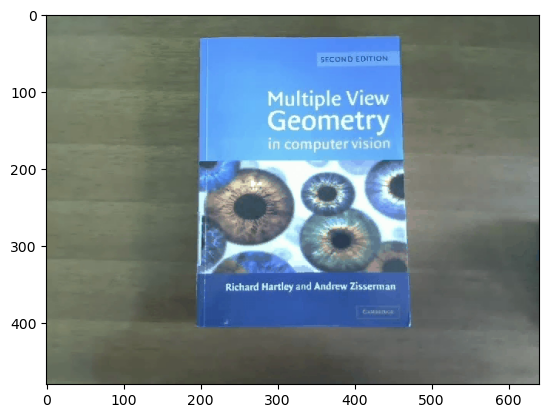

Object Binary Mask


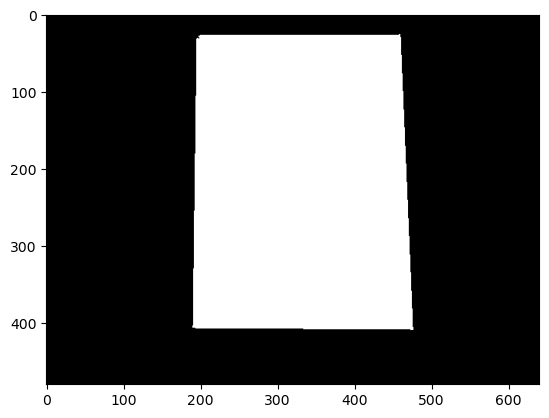

Updated Augmented Reality Layer


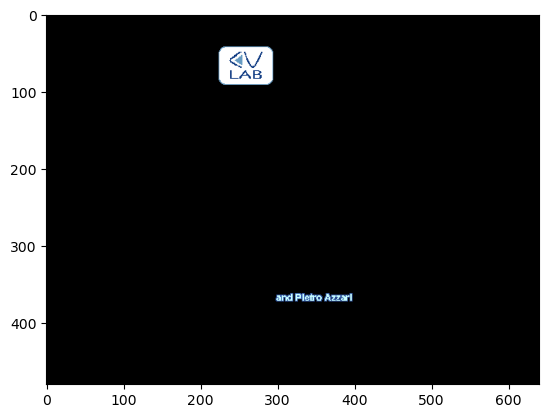

Updated Augmented Layer Binary Mask


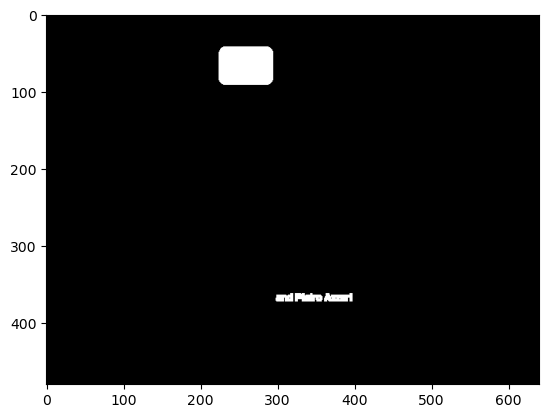

In [3]:
# Show the rgb version of the reference frame
show_image(reference_frame_rgb, "Reference Frame")

# Show the provided object binary mask
show_image(object_mask, "Object Binary Mask")

# Show the rgb version of the augmented reality layer
show_image(augmented_layer_rgb, "Updated Augmented Reality Layer")

# Show the provided augmented layer binary mask
show_image(augmented_layer_mask, "Updated Augmented Layer Binary Mask")

Towards the end of the video the brightness of the scene changes rapidly and this means that superimposing just the augmented layer _(CVLab logo + 3<sup>rd</sup> author)_ would result in the book rapidly changing colors/brightness but not the augmented layer. <br/>
One of the requirement of the project is that "one would perceive the overlaid graphics as real items present in the book cover" but because of the last few frames of the video, this cannot be achieved consistently. <br/>
The proposed solutions here merge the binary mask of the whole book with the modified one of the augmented layer and superimposes this new mask. This makes the brightness changes in the scene almost unnoticeable thus achieving the requested "as realistically as possible" superimposition. <br/><br/>
**Note**: the code is written in such a way that if one wants to superimpose just the CVLab logo + new author, just one variable should be changed _(see section 2)_.

Apply the binary masks to obtain an isolated image of the book and its augmented counterpart

In [4]:
# Apply the object mask to the reference frame to isolate the book
target_image = cv2.bitwise_and(reference_frame_rgb, object_mask)

# Use the just-created image of the book and superimpose the augmented
# layer according to the augmented layer binary mask
target_image_augmented = target_image.copy()
target_image_augmented[np.where(augmented_layer_mask == 255)] = augmented_layer_rgb[np.where(augmented_layer_mask == 255)]

# For comparison, merge the augmented image and the reference frame
reference_frame_rgb_augmented = reference_frame_rgb.copy()
reference_frame_rgb_augmented[np.where(object_mask == 255)] = target_image_augmented[np.where(object_mask == 255)]

Show the results of the masking

Isolated book


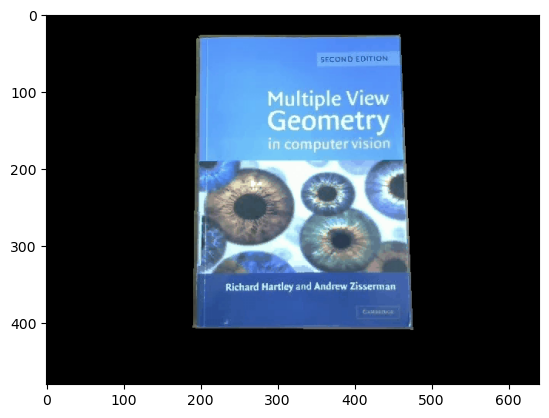

Augmented book


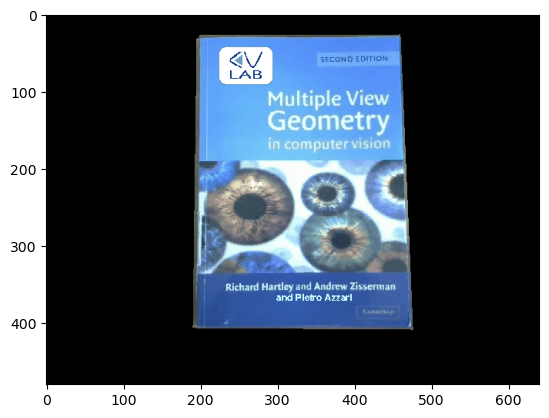

Augmented Reference Frame


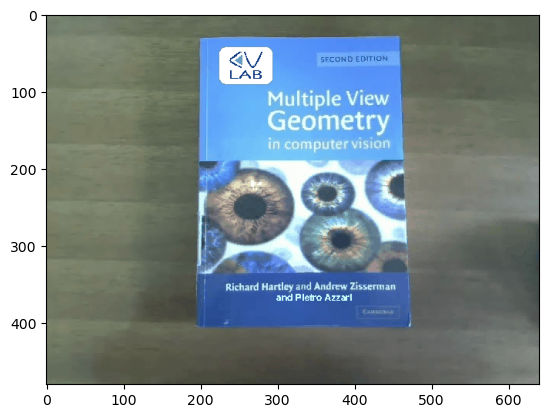

In [5]:
# Show the isolated version of the book 
show_image(target_image, "Isolated book")

# Show the isolated version of the augmented book 
show_image(target_image_augmented, "Augmented book")

# Show the augmented version of the reference frame
show_image(reference_frame_rgb_augmented, "Augmented Reference Frame")

# 2 Proposed Solutions

In this section, 3 solutions for the superimposition of an AR layer are proposed. <br/>

**Note**: the `SUPERIMPOSE_ORIGINAL_AR_LAYER` variable controls if the AR layer should be the whole book cover or just the CVLab logo + 3<sup>rd</sup> author. Output folders are automatically adjusted accordingly. If the value of this variable is changed a re-run of the sections 2.a, 2.b, 2.c is needed. <br/> 

In [6]:
SUPERIMPOSE_ORIGINAL_AR_LAYER = False #change to True for superimposing only the CVLab logo and the new author

if SUPERIMPOSE_ORIGINAL_AR_LAYER:
    final_augmented_frame = augmented_layer_rgb
    final_augmented_mask = augmented_layer_mask
    ar_folder = "AR CVLab logo and author"
else:
    final_augmented_frame = target_image_augmented
    final_augmented_mask = object_mask
    ar_folder = "AR Book"

# 2.a - Frame to Reference aproach (F2R) 


In this section an homography between the reference frame and the currently played frame is found and then the augmented reality layer is projected onto the current frame according to the found homography.

In [7]:
# Video playback variables
frame_num = 0 
F2R_frames_buffer = []

# Initial keypoints to keep track of
kp_query, des_query = run_SIFT(reference_frame_grayscale)

# Initializing the matching algorithm
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)
flann = cv2.FlannBasedMatcher(index_params, search_params)

def process_video_F2R(current_frame, previous_frame):
    global frame_num
    global kp_query
    global des_query
    
    frame_num += 1
    clear_output(wait = True)
    print(f"Frames processed: {frame_num} / {TOT_FRAMES_NUM}")
    
    # First frame already processed
    if previous_frame is None:
        F2R_frames_buffer.append(reference_frame_rgb_augmented)
        return
    
    # Create a grayscale version of the current_frame for SIFT
    current_frame_grayscale = cv2.cvtColor(current_frame, cv2.COLOR_BGR2GRAY)

    # Run SIFT on the current frame
    kp_train, des_train = run_SIFT(current_frame_grayscale)

    # Matching the descriptors
    matches = flann.knnMatch(des_query, des_train, k = 2)

    # Keeping only good matches as per Lowe's ratio test
    good = []
    for m,n in matches:
        if m.distance < 0.7 * n.distance:
            good.append(m)

    # Check if SIFT found the minimum number of matches
    if len(good) < MIN_MATCH_COUNT:
        return 
    
    src_pts = np.float32([ kp_query[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp_train[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

    # Calculating homography based on correspondences
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    
    # Warping the augmented version of the book
    warped_augmented_frame = cv2.warpPerspective(
        final_augmented_frame,
        M, 
        (reference_frame_cols, reference_frame_rows)
    )

    # Warp a white mask to use as the place to put the augmented layer's pixels onto
    warp_mask = cv2.warpPerspective(
        final_augmented_mask,
        M, 
        (reference_frame_cols, reference_frame_rows)
    )
    warp_mask_white_pixels = np.where(warp_mask == 255)

    # Superimpose the augmented reality layer over the current frame
    final_frame = cv2.cvtColor(current_frame, cv2.COLOR_BGR2RGB)
    final_frame[warp_mask_white_pixels] = warped_augmented_frame[warp_mask_white_pixels]
    
    F2R_frames_buffer.append(final_frame)
    
    """
    # Display the frame (computation takes more time)
    #show_image(final_frame, None, False)
    
    # Matches mask for visualization of only matches used by RANSAC
    matches_mask = mask.ravel().tolist()

    # Draw the matches
    draw_params = dict(
        matchColor = (0,255,0), # draw matches in green color
        singlePointColor = None,
        matchesMask = matches_mask, # draw only inliers
        flags = 2
    )
    comparison_img = cv2.drawMatches(
        reference_frame_rgb,
        kp_query,
        final_frame,
        kp_train,
        good,
        None,
        **draw_params
    )
    show_image(comparison_img, None, False)
    """

start = time.time()
process_video(video_path, process_video_F2R)
print(f"Elapsed Time: {time.time() - start}")

Frames processed: 420 / 420
Elapsed Time: 33.39428091049194


Play the result of the F2R augmentation 

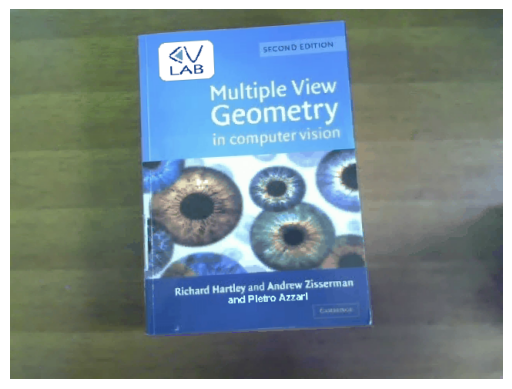

In [8]:
play_video_frames(F2R_frames_buffer)

The book cover seems a bit shaky, this could be due either to noise or to the SIFT method failing to precisely match enough good  keypoints of the reference frame to the ones of the other frames.

# 2.b - Frame to Frame aproach (F2F) - SIFT only

In this section we keep track of every homography found between two consecutive frames and use their dot product (we apply them one after another) to superimpose the augmented reality layer onto the current frame.

In [9]:
# Video playback variables
frame_num = 0
F2F_frames_buffer = []

# SIFT variables
homography_matrix = np.identity(3, dtype = np.float32) #3x3 identity matrix

# Initial keypoints to keep track of
kp_query, des_query = run_SIFT(reference_frame_grayscale)

# Initializing the matching algorithm
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)
flann = cv2.FlannBasedMatcher(index_params, search_params)

def process_video_F2F(current_frame, previous_frame):
    global frame_num
    global kp_query
    global des_query
    global homography_matrix
    
    frame_num += 1
    clear_output(wait = True)
    print(f"Frames processed: {frame_num} / {TOT_FRAMES_NUM}")
    
    # First frame already processed
    if previous_frame is None:
        F2F_frames_buffer.append(reference_frame_rgb_augmented)
        return
    
    # Create a grayscale version of the current_frame for SIFT
    current_frame_grayscale = cv2.cvtColor(current_frame, cv2.COLOR_BGR2GRAY)
    
    # Run SIFT on the current frame
    kp_train, des_train = run_SIFT(current_frame_grayscale)

    # Matching the descriptors
    matches = flann.knnMatch(des_query, des_train, k = 2)

    # Keeping only good matches as per Lowe's ratio test
    good = []
    for m,n in matches:
        if m.distance < 0.7 * n.distance:
            good.append(m)
            
    # Check if SIFT found the minimum number of matches
    if len(good) < MIN_MATCH_COUNT:
        return 
        
    src_pts = np.float32([kp_query[m.queryIdx].pt for m in good]).reshape(-1,1,2)
    dst_pts = np.float32([kp_train[m.trainIdx].pt for m in good]).reshape(-1,1,2)
    
    # Calculating homography based on correspondences
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

    # Use the current homography to update the total homography matrix
    homography_matrix = np.dot(homography_matrix, M)

    # Warping the augmented version of the book
    warped_augmented_frame = cv2.warpPerspective(
        final_augmented_frame, 
        homography_matrix, 
        (reference_frame_cols, reference_frame_rows)
    )

    # Warp a white mask to use as the place to put the augmented layer's pixels onto
    warp_mask = cv2.warpPerspective(
        final_augmented_mask, 
        homography_matrix, 
        (reference_frame_cols, reference_frame_rows)
    )
    warp_mask_white_pixels = np.where(warp_mask == 255)
    
    # Superimpose the augmented reality layer over the current frame
    final_frame = cv2.cvtColor(current_frame, cv2.COLOR_BGR2RGB)
    final_frame[warp_mask_white_pixels] = warped_augmented_frame[warp_mask_white_pixels]

    F2F_frames_buffer.append(final_frame)
        
    """
    # Display the frame (computation take more time)
    #show_image(final_frame, None, False)

    # Matches mask for visualization of only matches used by RANSAC
    matches_mask = mask.ravel().tolist()

    # Draw the matches
    draw_params = dict(
        matchColor = (0,255,0), # draw matches in green color
        singlePointColor = None,
        matchesMask = matches_mask, # draw only inliers
        flags = 2
    )    
    comparison_img = cv2.drawMatches(
        cv2.cvtColor(previous_frame, cv2.COLOR_BGR2RGB),
        kp_query,
        final_frame,
        kp_train,
        good,
        None,
        **draw_params
    )
    show_image(comparison_img, None, False)
    """
    
    # Update the previous image keypoints and descriptors for the next frame
    kp_query, des_query = kp_train, des_train

    
start = time.time()
process_video(video_path, process_video_F2F)
print(f"Elapsed Time: {time.time() - start}")

Frames processed: 420 / 420
Elapsed Time: 33.173080921173096


Play the result of the F2F augmentation 

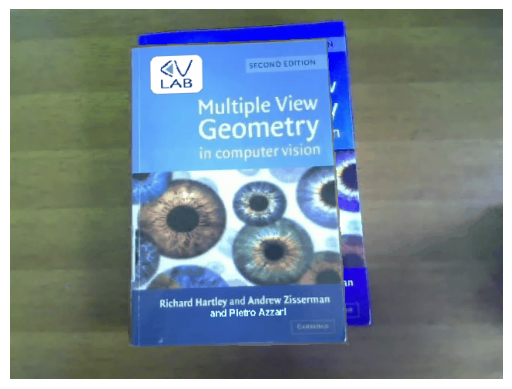

In [10]:
play_video_frames(F2F_frames_buffer)

The book cover isn't as shaky as before but now there's some difference between the augmented reality layer and the frames positions.
This could be due to some imprecision of the SIFT keypoints/descriptors (perhaps the same as before) which frame by frame makes the dot product of the newly found homography and the previous ones slightly less correct than before. 

# 2.c - Frame to Frame aproach (F2F) - SIFT + Lucas-Kanade

Like in the 2.b section, now we keep track of every homography found between two consecutive frames and use the dot product of all the homographies found to superimpose the augmented reality layer onto the current frame. This time though, in order to find homographies we track the optical flow of the keypoints via the Lucas-Kanade method. Like in the 2.a section, every N Frames we find the homography between the reference frame and the current frame and use this value to correct the drift seen in section 2.b.

In [11]:
# Video playback variables
frame_num = 0
F2FLK_frames_buffer = []

# SIFT variables
homography_matrix = np.identity(3, dtype = np.float32) #3x3 identity matrix

# Initial keypoints to keep track of
kp_query, des_query = run_SIFT(reference_frame_grayscale)
old_pts = np.float32([kp.pt for kp in kp_query]).reshape(-1,1,2)

# Initializing the matching algorithm
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)
flann = cv2.FlannBasedMatcher(index_params, search_params)

# Parameters for Lucas-Kanade optical flow
lk_params = dict( 
    winSize = (15, 15),
    maxLevel = 4,
    criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03)
)

previous_frame_grayscale = reference_frame_grayscale

def process_video_F2FLK(current_frame, previous_frame):
    global frame_num
    global homography_matrix
    global previous_frame_grayscale
    global old_pts
    global kp_query
    global des_query
    
    frame_num += 1
    clear_output(wait = True)
    print(f"Frames processed: {frame_num} / {TOT_FRAMES_NUM}")
    
    # First frame already processed
    if previous_frame is None:
        F2FLK_frames_buffer.append(reference_frame_rgb_augmented)
        return
    
    # Create a grayscale version of the current_frame
    current_frame_grayscale = cv2.cvtColor(current_frame, cv2.COLOR_BGR2GRAY)
    
    # Every SIFT_FREQUENCY_2C frames, run SIFT on the current frame
    if frame_num % SIFT_FREQUENCY_2C == 0:
        kp_train, des_train = run_SIFT(current_frame_grayscale)

        # Matching the descriptors
        matches = flann.knnMatch(des_query, des_train, k = 2)

        # Keeping only good matches as per Lowe's ratio test
        good = []
        for m,n in matches:
            if m.distance < 0.7 * n.distance:
                good.append(m)

        # Check if SIFT found the minimum number of matches
        if len(good) < MIN_MATCH_COUNT:
            return 

        src_pts = np.float32([kp_query[m.queryIdx].pt for m in good]).reshape(-1,1,2)
        dst_pts = np.float32([kp_train[m.trainIdx].pt for m in good]).reshape(-1,1,2)
        new_pts = dst_pts
        
        # Calculating homography based on correspondences
        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
        
        # Adjust the homography matrix via the SIFT-found homography (take the mean of the two)
        homography_matrix = np.mean(np.array([homography_matrix, M]), axis = 0)
    else:  
        # Calculate optical flow via Lucas-Kanade method
        new_pts, status, err = cv2.calcOpticalFlowPyrLK(
            previous_frame_grayscale,
            current_frame_grayscale,
            old_pts, 
            None,
            **lk_params
        )

        # Filter out points that the LK method was not able to estimate the optical flow of
        good_new = new_pts[status == 1]
        good_old = old_pts[status == 1]

        # Check if we found the minimum number of matches for an homography
        if len(good_new) < 4:
            return 

        # Calculating homography based on correspondences
        M, mask = cv2.findHomography(good_old, good_new, cv2.RANSAC, 5.0)
    
        # Use the current homography to update the total homography matrix
        homography_matrix = np.dot(homography_matrix, M)
    
    # Update previous references
    previous_frame_grayscale = current_frame_grayscale
    old_pts = new_pts    
    
    # Warping the augmented version of the book
    warped_augmented_frame = cv2.warpPerspective(
        final_augmented_frame, 
        homography_matrix, 
        (reference_frame_cols, reference_frame_rows)
    )

    # Warp a white mask to use as the place to put the augmented layer's pixels onto
    warp_mask = cv2.warpPerspective(
        final_augmented_mask, 
        homography_matrix, 
        (reference_frame_cols, reference_frame_rows),
    )
    warp_mask_white_pixels = np.where(warp_mask == 255)
    
    # Superimpose the augmented reality layer over the current frame
    final_frame = cv2.cvtColor(current_frame, cv2.COLOR_BGR2RGB)
    final_frame[warp_mask_white_pixels] = warped_augmented_frame[warp_mask_white_pixels]

    F2FLK_frames_buffer.append(final_frame)

    # Display the frame (computation take more time)
    #show_image(final_frame, None, False)

start = time.time()
process_video(video_path, process_video_F2FLK)
print(f"Elapsed Time: {time.time() - start}")

Frames processed: 420 / 420
Elapsed Time: 10.54356050491333


Play the result of the F2FLK augmentation

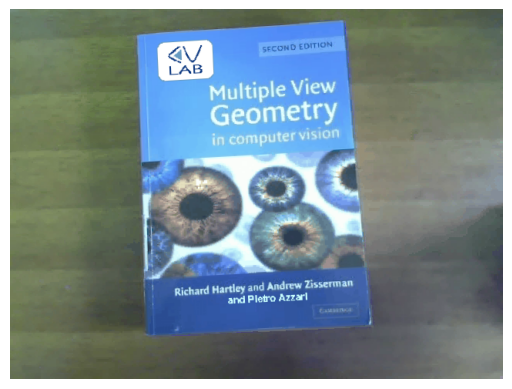

In [12]:
play_video_frames(F2FLK_frames_buffer)

This last aproach seems to have alleviated the shakiness problem of the 2.a solution and (almost) completly corrected the drift introduced by the 2.b solution. Plus, it runs 3 times faster than the other two methods (on my machine at least). 

# 3 - Results comparison and file savings

In this sections all the previously produced array buffers are played as if they were videos and saved on the disk at the same time. Furthermore, they're combined together for comparison purposes. <br/>
The default folder for the output videos is called `Output` and it's in the same folder of this file. <br/>

All the video sequences are already available at [this GitHub repository.](https://github.com/CristianDavideConte/computer_vision_project)

**Note:** By default the video playbacks are disabled since they make the saving process a lot slower.

In [13]:
play_video_opt = False #change to True to show the video sequences while saving the files locally

**F2R** results and savings

In [14]:
dir = os.path.abspath(output_folder + ar_folder + output_F2R_folder)
filepath = os.path.abspath(output_folder + ar_folder + output_video_F2R_path)

# Check if the output directory exists, if not: create it
if not os.path.exists(dir) or not os.path.isdir(dir):
    os.makedirs(dir)

video_writer_F2R = cv2.VideoWriter(
    filepath,                     
    cv2.VideoWriter_fourcc(*"DIVX"),             #MPEG-4 codec
    SAVED_VIDEO_FPS,                             #fps
    (reference_frame_cols, reference_frame_rows) #width x height
)
    
play_video_frames(
    F2R_frames_buffer, 
    "F2R" if play_video_opt == False else None, 
    False, 
    lambda frame: video_writer_F2R.write(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)), #saves the video locally
    play_video_opt, 
) 

video_writer_F2R.release()

clear_output(wait = True)
print(f"Processing finished.\nThe video is available at: {filepath}")

Processing finished.
The video is available at: C:\Users\crist\Desktop\Computer Vision and Image Processing M\Progetto\Outputs\AR Book\F2R\Augmented Multiple View.avi


**F2F** results and savings

In [15]:
dir = os.path.abspath(output_folder + ar_folder + output_F2F_folder)
filepath = os.path.abspath(output_folder + ar_folder + output_video_F2F_path)

# Check if the output directory exists, if not: create it
if not os.path.exists(dir) or not os.path.isdir(dir):
    os.makedirs(dir)

video_writer_F2F = cv2.VideoWriter(
    filepath,                     
    cv2.VideoWriter_fourcc(*"DIVX"),             #MPEG-4 codec
    SAVED_VIDEO_FPS,                             #fps
    (reference_frame_cols, reference_frame_rows) #width x height
)

play_video_frames(
    F2F_frames_buffer, 
    "F2F" if play_video_opt == False else None, 
    False, 
    lambda frame: video_writer_F2F.write(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)), #saves the video locally
    play_video_opt,
) 

video_writer_F2F.release()

clear_output(wait = True)
print(f"Processing finished.\nThe video is available at: {filepath}")

Processing finished.
The video is available at: C:\Users\crist\Desktop\Computer Vision and Image Processing M\Progetto\Outputs\AR Book\F2F\Augmented Multiple View.avi


**F2FLK** results and savings

In [16]:
dir = os.path.abspath(output_folder + ar_folder + output_F2FLK_folder)
filepath = os.path.abspath(output_folder + ar_folder + output_video_F2FLK_path)

# Check if the output directory exists, if not: create it
if not os.path.exists(dir) or not os.path.isdir(dir):
    os.makedirs(dir)

video_writer_F2FLK = cv2.VideoWriter(
    filepath,                     
    cv2.VideoWriter_fourcc(*"DIVX"),             #MPEG-4 codec
    SAVED_VIDEO_FPS,                             #fps
    (reference_frame_cols, reference_frame_rows) #width x height
)
    
play_video_frames(
    F2FLK_frames_buffer, 
    "F2FLK" if play_video_opt == False else None, 
    False, 
    lambda frame: video_writer_F2FLK.write(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)), #saves the video locally
    play_video_opt,
) 

video_writer_F2FLK.release()

clear_output(wait = True)
print(f"Processing finished.\nThe video is available at: {filepath}")

Processing finished.
The video is available at: C:\Users\crist\Desktop\Computer Vision and Image Processing M\Progetto\Outputs\AR Book\F2FLK\Augmented Multiple View.avi


Comparison between **F2R** and **F2F**

In [17]:
dir = os.path.abspath(output_folder + ar_folder + output_comparisons_folder)
filepath = os.path.abspath(output_folder + ar_folder + output_video_F2R_F2F_path)

# Check if the output directory exists, if not: create it
if not os.path.exists(dir) or not os.path.isdir(dir):
    os.makedirs(dir)

video_writer_F2R_F2F = cv2.VideoWriter(
    filepath,                     
    cv2.VideoWriter_fourcc(*"DIVX"),                 #MPEG-4 codec
    SAVED_VIDEO_FPS,                                 #fps
    (2 * reference_frame_cols, reference_frame_rows) #width x height
)
    
play_video_frames_side_by_side(
    F2R_frames_buffer, 
    F2F_frames_buffer, 
    "F2R (left) vs F2F (right)" if play_video_opt == False else None, 
    False, 
    lambda frame: video_writer_F2R_F2F.write(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)), #saves the video locally
    play_video_opt,
) 

video_writer_F2R_F2F.release()

clear_output(wait = True)
print(f"Processing finished.\nThe video is available at: {filepath}")

Processing finished.
The video is available at: C:\Users\crist\Desktop\Computer Vision and Image Processing M\Progetto\Outputs\AR Book\Comparisons\Augmented Multiple View - F2R vs F2F.avi


Comparison between **F2F** and **F2FLK**

In [18]:
dir = os.path.abspath(output_folder + ar_folder + output_comparisons_folder)
filepath = os.path.abspath(output_folder + ar_folder + output_video_F2F_F2FLK_path)

# Check if the output directory exists, if not: create it
if not os.path.exists(dir) or not os.path.isdir(dir):
    os.makedirs(dir)
    
video_writer_F2F_F2FLK = cv2.VideoWriter(
    filepath, 
    cv2.VideoWriter_fourcc(*"DIVX"),                 #MPEG-4 codec
    SAVED_VIDEO_FPS,                                 #fps
    (2 * reference_frame_cols, reference_frame_rows) #width x height
)
    
play_video_frames_side_by_side(
    F2F_frames_buffer, 
    F2FLK_frames_buffer, 
    "F2F (left) vs F2FLK (right)" if play_video_opt == False else None, 
    False, 
    lambda frame: video_writer_F2F_F2FLK.write(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)), #saves the video locally
    play_video_opt,
)

video_writer_F2F_F2FLK.release()

clear_output(wait = True)
print(f"Processing finished.\nThe video is available at: {filepath}")

Processing finished.
The video is available at: C:\Users\crist\Desktop\Computer Vision and Image Processing M\Progetto\Outputs\AR Book\Comparisons\Augmented Multiple View - F2F vs F2FLK.avi


Comparison between **F2R** and **F2FLK**

In [19]:
dir = os.path.abspath(output_folder + ar_folder + output_comparisons_folder)
filepath = os.path.abspath(output_folder + ar_folder + output_video_F2R_F2FLK_path)

# Check if the output directory exists, if not: create it
if not os.path.exists(dir) or not os.path.isdir(dir):
    os.makedirs(dir)
    
video_writer_F2R_F2FLK = cv2.VideoWriter(
    filepath, 
    cv2.VideoWriter_fourcc(*"DIVX"),                 #MPEG-4 codec
    SAVED_VIDEO_FPS,                                 #fps
    (2 * reference_frame_cols, reference_frame_rows) #width x height
)
    
play_video_frames_side_by_side(
    F2R_frames_buffer, 
    F2FLK_frames_buffer, 
    "F2R (left) vs F2FLK (right)" if play_video_opt == False else None, 
    False,
    lambda frame: video_writer_F2R_F2FLK.write(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)), #saves the video locally
    play_video_opt,
) 

video_writer_F2R_F2FLK.release()

clear_output(wait = True)
print(f"Processing finished.\nThe video is available at: {filepath}")

Processing finished.
The video is available at: C:\Users\crist\Desktop\Computer Vision and Image Processing M\Progetto\Outputs\AR Book\Comparisons\Augmented Multiple View - F2R vs F2FLK.avi
